In [1]:
import pandas as pd
import numpy as np
import math, re, os, cv2
import random
import gc
from tqdm import tqdm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
# from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from skimage.util import random_noise
from skimage.transform import rotate, AffineTransform, warp

Tensorflow version 2.10.1


c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want

In [2]:
# test for GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import tensorflow as tf

def set_gpu_device():

    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Call the function to set GPU device

set_gpu_device()
if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("No GPU found. TensorFlow will use the CPU.")

GPU is available!


In [4]:
# path of damage and non-damage datasets
path = '../good_japan/'
path2 = '../damage_imgs/'

In [5]:
# augment non-damage imgs
# def anticlockwise_rotation(image):
#     angle= random.randint(0,180)
#     return rotate(image, angle)

# def clockwise_rotation(image):
#     angle= random.randint(0,180)
#     return rotate(image, -angle)

# def h_flip(image):
#     return  np.fliplr(image)

# def v_flip(image):
#     return np.flipud(image)

# def add_noise(image):
#     return random_noise(image)

# def blur_image(image):
#     return cv2.GaussianBlur(img, (9,9),0)

#I would not recommend warp_shifting, because it distorts image, but can be used in many use case like 
#classifying blur and non-blur images
# def warp_shift(image): 
#     transform = AffineTransform(translation=(0,40))  #chose x,y values according to your convinience
#     warp_image = warp(image, transform, mode="wrap")
#     return warp_image

In [6]:
# aug_images=[]
# for i in tqdm(all_images):
#     img = add_noise(i)
#     img = blur_image(img)
#     img = warp_shift(img)
#     aug_images.append(img)
# aug_images = np.array(aug_images)

can not do augmentation due to memory and img size

re-shape and comment the wrap_shift

In [5]:
# Load and Preprocess all the non-damage images for training
# with re-size
all_images = []
import os
import tensorflow as tf
from tqdm import tqdm

img_list = os.listdir(path)
for i in tqdm(img_list):
    # Load the image in grayscale and resize it
    img = tf.keras.preprocessing.image.load_img(
        os.path.join(path, i), 
        target_size=(128, 128), 
        color_mode='grayscale'
    )
    # Convert the image to a numpy array
    img = tf.keras.preprocessing.image.img_to_array(img)
    # Normalize the image data
    img = img / 255.0
    # Append the processed image to the list
    all_images.append(img)
    
# Convert the list of images to a numpy array
all_images = np.array(all_images)
print("Shape of the images array:", all_images.shape)

  0%|          | 0/6472 [00:00<?, ?it/s]

100%|██████████| 6472/6472 [00:27<00:00, 237.51it/s]


Shape of the images array: (6472, 128, 128, 1)


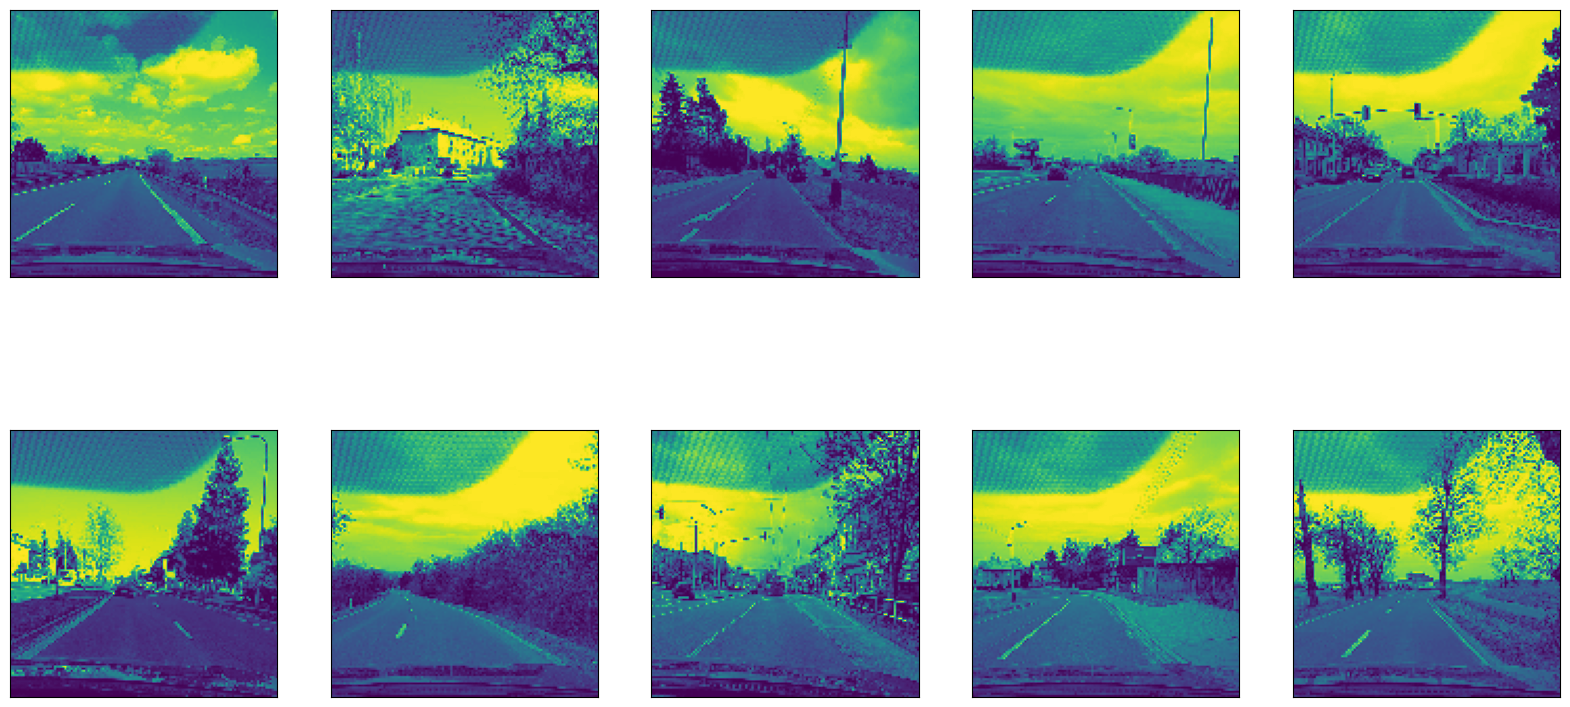

In [7]:
#Show non-damage images
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(all_images[i+50])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(all_images[i+20])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [8]:
# Config hyperparameters
IMAGE_SIZE = [128,128]
SEED = 42
n_hidden_1 = 512
n_hidden_2 = 256
n_hidden_3 = 64 
n_hidden_4 = 16
n_hidden_5 = 8
convkernel = (3, 3)  # convolution kernel
poolkernel = (2, 2)  # pooling kernel

In [9]:
#seeds
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [10]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


## Customized autoencoder architecture

In [14]:
def get_model():
    K.clear_session()
    with strategy.scope():
        inp1 = tf.keras.layers.Input(shape = (128, 128, 1))

        x = tf.keras.layers.Conv2D(n_hidden_1, convkernel, activation='relu', padding='same')(inp1)
        x = tf.keras.layers.Conv2D(n_hidden_1, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_3, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_4, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)#

        x = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)
        encoded = tf.keras.layers.Conv2D(n_hidden_5, convkernel, activation='relu', padding='same')(x)


        #decoder
        x = tf.keras.layers.Conv2DTranspose(n_hidden_5, convkernel, strides=2, activation='relu', padding='same')(encoded)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_4, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_3, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_2, convkernel, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(n_hidden_1, convkernel, strides=1, activation='relu', padding='same')(x)

        decoded = tf.keras.layers.Conv2DTranspose(1, convkernel, activation="sigmoid", padding='same')(x)

        model = tf.keras.models.Model(inputs = inp1, outputs = decoded)

        opt = tfa.optimizers.RectifiedAdam(lr=3e-4)
        model.compile(
            optimizer = opt,
            loss = 'mse',
            metrics = [tf.keras.metrics.RootMeanSquaredError()]
        )

        return model

## Used Pretrained VGG19 for Encoder

## Transposed convolution for Decoder

VGG19 is pretrained for color imgs

change the original VGG19 structure to adjust for greyscale

In [12]:
# def get_custom_vgg19():
#     K.clear_session()
#     with strategy.scope():
#         image_input = tf.keras.layers.Input(shape = (128, 128, 1))
        
#         # not working with vg19 anymore so comment out
#         # vg19 = tf.keras.applications.VGG19(input_tensor = image_input, weights = 'imagenet', include_top=False)
#         # encoded = vg19.get_layer('block5_pool').output

#         # Example of adapting the first few layers of VGG19

#         # Encoder
#         x = tf.keras.layers.Conv2D(n_hidden_1, convkernel, activation='relu', padding='same')(image_input)
#         # x = tf.keras.layers.Conv2D(n_hidden_1, convkernel, activation='relu', padding='same')(x)
#         x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)

#         # x = tf.keras.layers.Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
#         x = tf.keras.layers.Conv2D(n_hidden_2, convkernel, activation='relu', padding='same')(x)
#         x = tf.keras.layers.MaxPooling2D(poolkernel, padding='same')(x)

#         # Decoder
#         x = tf.keras.layers.Conv2DTranspose(n_hidden_2, convkernel, strides=2, activation='relu', padding='same')(x)
#         x = tf.keras.layers.Conv2DTranspose(n_hidden_1, convkernel, strides=2, activation='relu', padding='same')(x)
        
#         # Final layer to get back to original image shape and single channel
#         decoded = tf.keras.layers.Conv2DTranspose(1, convkernel, activation='sigmoid', padding='same')(x)
        
#         model = tf.keras.models.Model(inputs = image_input, outputs = decoded)
#         opt = tfa.optimizers.RectifiedAdam(lr=3e-4)
#         model.compile(
#             optimizer = opt,
#             loss = 'mse',
#             metrics = [tf.keras.metrics.RootMeanSquaredError()]
#         )
#         return model

In [14]:
# simplify model structure
# def get_custom_vgg19():
#     K.clear_session()
#     with strategy.scope():
#         # Adjust the input shape to match your grayscale images
#         image_input = tf.keras.layers.Input(shape=(128, 128, 1))

#         # Create a VGG-like model for grayscale images
#         # Note: Since we are not using the original VGG19, weights are not pretrained on ImageNet
#         x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(image_input)
#         x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#         x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2))(x)
#         # ... continue adding VGG-like layers ...

#         # Get to the bottleneck of the model
#         # Ensure that the output shape here matches the input shape of the first layer of the decoder

#         # Decoder (mirror the encoder architecture in reverse)
#         x = tf.keras.layers.Conv2DTranspose(n_hidden_1, convkernel, strides=2, activation='relu', padding='same')(x)
#         # ... continue adding upsampling layers to match the encoder architecture in reverse ...
#         decoded = tf.keras.layers.Conv2DTranspose(1, convkernel, activation="sigmoid", padding='same')(x)

#         model = tf.keras.models.Model(inputs=image_input, outputs=decoded)
#         opt = tfa.optimizers.RectifiedAdam(lr=3e-4)
#         model.compile(
#             optimizer=opt,
#             loss='mse',
#             metrics=[tf.keras.metrics.RootMeanSquaredError()]
#         )
#         return model


In [15]:
# model=  get_custom_vgg19() #get_model()
model = get_model()
model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 512)     5120      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 512)     2359808   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 512)      0         
 )                                                               
                                             

In [16]:
#Split the dataset into train and test with a ratio of 80:20.
X_train, X_test = train_test_split(all_images, test_size=0.2, random_state=SEED)
print(X_train.shape, X_test.shape)

(5177, 128, 128, 1) (1295, 128, 128, 1)


In [17]:
del all_images;  gc.collect()

4224

In [18]:
#model training config params

# change the epoch to 15 for testing
# EPOCHS = 100
EPOCHS = 15
# BATCH_SIZE = 16
# reduce batch_size to make training run
BATCH_SIZE = 8
NUM_TRAINING_IMAGES = X_train.shape[0]
steps = NUM_TRAINING_IMAGES // BATCH_SIZE
NUM_VALID_IMAGES = X_test.shape[0]
val_steps = NUM_VALID_IMAGES // BATCH_SIZE

In [19]:
# import tensorflow as tf
# from tensorflow.keras import mixed_precision
# # from tensorflow.keras.mixed_precision import experimental as mixed_precision

# sav = tf.keras.callbacks.ModelCheckpoint(
    
#     'Enc'+'.h5', monitor='val_loss', verbose=1, save_best_only=True,
#     save_weights_only=True, mode='min', save_freq='epoch')
# # lr scheduler
# cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4, patience = 2,
#                                                       verbose = 1, mode = 'min',min_delta = 0.0001)

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, 
#                                                   verbose = 1, min_delta = 0.0001)

# # Check if the GPU supports mixed precision
# if tf.config.experimental.list_physical_devices('GPU'):
    
#     policy = mixed_precision.Policy('mixed_float16')
#     # policy = mixed_precision.set_global_policy
#     # mixed_precision.set_policy(policy)
#     print('Mixed precision enabled')

# # Now construct, compile, and train your model as usual
# model = get_custom_vgg19()  # or your model function
# # model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer=tf.keras.optimizers.RMSprop(),
#               metrics=['accuracy'])

# model.fit(X_train, X_train,
#           validation_data=(X_test, X_test),
#           epochs=EPOCHS,
#           batch_size=BATCH_SIZE,
#           callbacks=[sav, cb_lr_schedule, early_stopping],
#           verbose=1)


Tried mixed strategies and not working

Will simplify the model by reducing the number of layers,  filters and neurons

In [19]:
#Model training
sav = tf.keras.callbacks.ModelCheckpoint(
    
    'Enc_o'+'.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='min', save_freq='epoch')
# lr scheduler
cb_lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4, patience = 2,
                                                      verbose = 1, mode = 'min',min_delta = 0.0001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, 
                                                  verbose = 1, min_delta = 0.0001)
model.fit(X_train, X_train,
      validation_data=(X_test, X_test),
      steps_per_epoch=steps,
      validation_steps=val_steps,
      epochs = EPOCHS,
      callbacks= [sav, cb_lr_schedule,early_stopping],
      verbose = 1)

Epoch 1/15
647/647 [==============================] - ETA: 0s - loss: 0.0449 - root_mean_squared_error: 0.2118WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 161 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: val_loss improved from inf to 0.02203, saving model to Enc_o.h5
647/647 [==============================] - 617s 753ms/step - loss: 0.0449 - root_mean_squared_error: 0.2118 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1484 - lr: 3.0000e-04
Epoch 2/15
647/647 [==============================] - 403s 622ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - lr: 3.0000e-04
Epoch 3/15
647/647 [==============================] - 394s 609ms/step - loss: 0.0160 - root_mean_squared_error: 0.1265 - lr: 3.0000e-04
Epoch 4/15
647/647 [==============================] - 391s 605ms/step - loss: 0.0151 - root_mea

In [20]:
model.save('AutoEncoder_original')

INFO:tensorflow:Assets written to: AutoEncoder_original\assets


INFO:tensorflow:Assets written to: AutoEncoder_original\assets


## Inference

In [21]:
model.load_weights('./Enc_o.h5')

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 512)     5120      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 512)     2359808   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 512)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 256)       590080    
                                                             

## Damage imgs for testing

In [24]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm

def preprocess_and_save_images(input_path, output_path, target_size=(128, 128)):
    processed_images = []
    img_list = os.listdir(input_path)

    for i in tqdm(img_list):
        img = tf.keras.preprocessing.image.load_img(
            os.path.join(input_path, i),
            target_size=target_size,
            color_mode='grayscale'
        )
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0
        processed_images.append(img)

    processed_images = np.array(processed_images)
    np.save(output_path, processed_images)
    print(f"Processed images saved to: {output_path}")
    return processed_images

# Path to the directory containing non-damage images
non_damage_images_path = '../good_japan/'
# Path to save the preprocessed non-damage images
output_non_damage_path = './non_damage_preprocessed.npy'

# Path to the directory containing damage images
damage_images_path = '../damage_imgs/'
# Path to save the preprocessed damage images
output_damage_path = './damage_preprocessed.npy'

# Preprocess and save non-damage images
non_damage_images = preprocess_and_save_images(non_damage_images_path, output_non_damage_path)

# Preprocess and save damage images
damage_images = preprocess_and_save_images(damage_images_path, output_damage_path)

  0%|          | 0/6472 [00:00<?, ?it/s]

100%|██████████| 6472/6472 [00:17<00:00, 360.36it/s]


Processed images saved to: ./non_damage_preprocessed.npy


100%|██████████| 7317/7317 [00:31<00:00, 234.74it/s]


Processed images saved to: ./damage_preprocessed.npy


In [25]:
damage_images= np.array(damage_images)
damage_images.shape

(7317, 128, 128, 1)

In [26]:
non_damage_images = np.array(non_damage_images)
non_damage_images.shape

(6472, 128, 128, 1)

In [31]:
# # import os
# # from tqdm import tqdm

# damage_images = []
# img_list = os.listdir(path2)

# for i in tqdm(img_list):
#     img = tf.keras.preprocessing.image.load_img(
#         path2+'/'+str(i), 
#         target_size=(128,128),
#         color_mode='grayscale'
#     )
#     img = tf.keras.preprocessing.image.img_to_array(img)
#     img = img/255.
#     damage_images.append(img)
    
# damage_images= np.array(damage_images)
# damage_images.shape

# # Load and Preprocess all damage images for testing
# # with re-size
# # img_list = os.listdir(path2)
# # for i in tqdm(img_list):
# #     # Load the image in grayscale and resize it
# #     img = tf.keras.preprocessing.image.load_img(
# #         os.path.join(path2, i), 
# #         target_size=(128, 128), 
# #         color_mode='grayscale'
# #     )
# #     # Convert the image to a numpy array
# #     img = tf.keras.preprocessing.image.img_to_array(img)
# #     # Normalize the image data
# #     img = img / 255.0
# #     # Append the processed image to the list
# #     damage_images.append(img)
    
# # Convert the list of images to a numpy array
# # damage_images = np.array(damage_images)
# # print("Shape of the images array:", damage_images.shape)

100%|██████████| 7265/7265 [00:54<00:00, 132.98it/s]


(7265, 128, 128, 1)

In [27]:
#Split the dataset into train and test with a ratio of 80:20.
X_test_train, X_test_damage = train_test_split(damage_images, test_size=0.001, random_state=SEED)
print(X_test_train.shape, X_test_damage.shape)

(7309, 128, 128, 1) (8, 128, 128, 1)


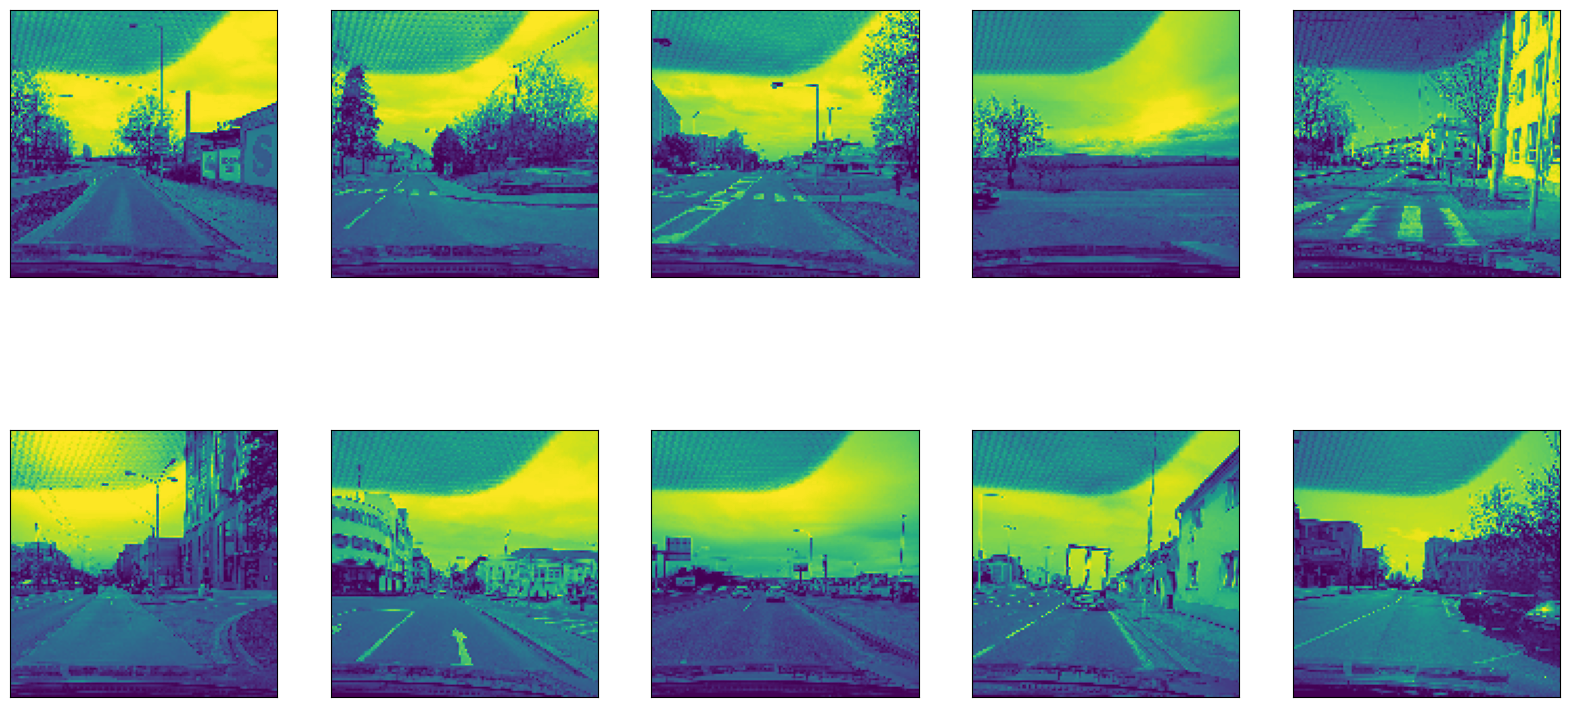

In [28]:
# show damage imgs
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(damage_images[i+50])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(damage_images[i+30])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [29]:
test_predictions =  model.predict(X_test_damage[:100])

1/1 [==============================] - 1s 1s/step


In [30]:
test_predictions[0]

array([[[0.51136583],
        [0.52662736],
        [0.5464932 ],
        ...,
        [0.58113843],
        [0.5662801 ],
        [0.5459995 ]],

       [[0.49699757],
        [0.5129135 ],
        [0.52779335],
        ...,
        [0.5759845 ],
        [0.56585187],
        [0.55500984]],

       [[0.5120247 ],
        [0.53998077],
        [0.55867803],
        ...,
        [0.5795565 ],
        [0.5723951 ],
        [0.56110567]],

       ...,

       [[0.3486893 ],
        [0.33163354],
        [0.32293063],
        ...,
        [0.3476149 ],
        [0.33646333],
        [0.34209305]],

       [[0.35046914],
        [0.31657907],
        [0.30772611],
        ...,
        [0.32162312],
        [0.31716833],
        [0.34104735]],

       [[0.3741268 ],
        [0.34189743],
        [0.32471424],
        ...,
        [0.31214836],
        [0.33129415],
        [0.37234288]]], dtype=float32)

In [31]:
X_test_damage[0].shape

(128, 128, 1)

No module named 'pyopencl'


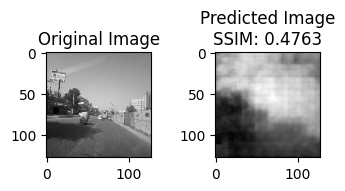

No module named 'pyopencl'


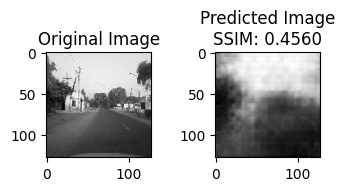

No module named 'pyopencl'


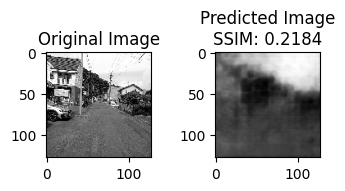

No module named 'pyopencl'


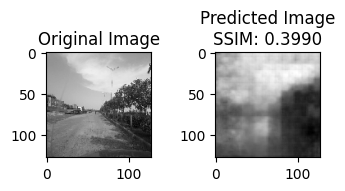

No module named 'pyopencl'


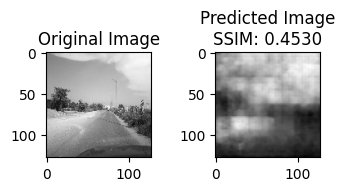

No module named 'pyopencl'


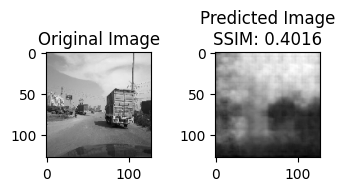

No module named 'pyopencl'


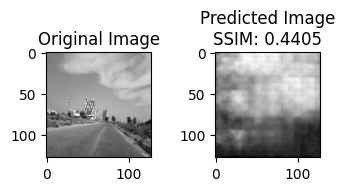

No module named 'pyopencl'


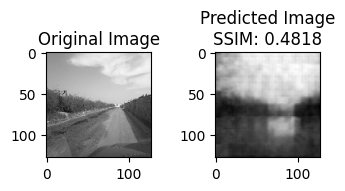

In [49]:
from SSIM_PIL import compare_ssim as ssim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def calculate_ssim(original_img, predicted_img):
    # Convert images to grayscale
    original_img = original_img.reshape((128, 128))
    formatted_original = (original_img * 255 / np.max(original_img)).astype('uint8')
    img_original = Image.fromarray(formatted_original)

    predicted_img = predicted_img.reshape((128, 128))
    formatted_predicted = (predicted_img * 255 / np.max(predicted_img)).astype('uint8')
    img_predicted = Image.fromarray(formatted_predicted)

    # Calculate SSIM
    ssim_value = ssim(img_original, img_predicted)
    return ssim_value

def plot_images(original_img, predicted_img, ssim_value):
    plt.figure(figsize=(4, 3))

    plt.subplot(2, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')

    plt.subplot(2, 2, 2)
    plt.imshow(predicted_img, cmap='gray')
    plt.title('Predicted Image\nSSIM: {:.4f}'.format(ssim_value))

    plt.show()

# Apply the function to all non damage images
for i in range(len(X_test_damage[:100])):
    # calculate_ssim(X_test_damage[i], test_predictions[i])
    plot_images(X_test_damage[i], test_predictions[i], calculate_ssim(X_test_damage[i], test_predictions[i]))

In [36]:
# Initialize variables to track cumulative loss and SSIM
# total_loss_non_damage = 0
total_ssim_non_damage = 0

# Apply the function to all non-damage images
for i in range(len(X_test[:8])):
    # Assuming `X_test` contains non-damage images
    original_img = X_test[i]
    predicted_img = model.predict(original_img.reshape(1, 128, 128, 1))

    # Calculate SSIM
    ssim_value_non_damage = calculate_ssim(original_img, predicted_img[0])
    total_ssim_non_damage += ssim_value_non_damage

# Calculate average SSIM for non-damage images
avg_ssim_non_damage = total_ssim_non_damage / len(X_test[:8])

# Print or use the average SSIM for non-damage images as needed
print("Average SSIM for non-damage images:", avg_ssim_non_damage)

1/1 [==============================] - 5s 5s/step
No module named 'pyopencl'
1/1 [==============================] - 0s 59ms/step
No module named 'pyopencl'
1/1 [==============================] - 0s 65ms/step
No module named 'pyopencl'
1/1 [==============================] - 0s 54ms/step
No module named 'pyopencl'
1/1 [==============================] - 0s 60ms/step
No module named 'pyopencl'
1/1 [==============================] - 0s 54ms/step
No module named 'pyopencl'
1/1 [==============================] - 0s 54ms/step
No module named 'pyopencl'
1/1 [==============================] - 0s 56ms/step
No module named 'pyopencl'
Average SSIM for non-damage images: 0.3806944249400052


In [37]:
# avg ssim for damage
total_ssim_damage = 0

# Apply the function to all non-damage images
for i in range(len(X_test_damage[:8])):
    # Assuming `X_test` contains non-damage images
    original_img = X_test_damage[i]
    predicted_img = model.predict(original_img.reshape(1, 128, 128, 1))

    # Calculate SSIM
    ssim_value_damage = calculate_ssim(original_img, predicted_img[0])
    total_ssim_damage += ssim_value_damage

# Calculate average SSIM for non-damage images
avg_ssim_damage = total_ssim_damage / len(X_test_damage[:8])

# Print or use the average SSIM for non-damage images as needed
print("Average SSIM for damage images:", avg_ssim_damage)

1/1 [==============================] - 0s 83ms/step
No module named 'pyopencl'
1/1 [==============================] - 0s 60ms/step
No module named 'pyopencl'
1/1 [==============================] - 0s 60ms/step
No module named 'pyopencl'
1/1 [==============================] - 0s 62ms/step
No module named 'pyopencl'
1/1 [==============================] - 0s 65ms/step
No module named 'pyopencl'
1/1 [==============================] - 0s 64ms/step
No module named 'pyopencl'
1/1 [==============================] - 0s 57ms/step
No module named 'pyopencl'
1/1 [==============================] - 0s 58ms/step
No module named 'pyopencl'
Average SSIM for damage images: 0.41585745135588076


In [38]:
# Load the pre-trained model
pre_trained_model = tf.keras.models.load_model('AutoEncoder_original')

total_loss_non_damage = 0

# Apply the function to all non-damage images
for i in range(len(X_test[:8])):
    # Assuming `X_test` contains non-damage images
    original_img = X_test[i]
    predicted_img = pre_trained_model.predict(original_img.reshape(1, 128, 128, 1))

    # Calculate and print the loss
    loss_values = pre_trained_model.evaluate(original_img.reshape(1, 128, 128, 1), predicted_img.reshape(1, 128, 128, 1))
    loss_value = loss_values[0]
    total_loss_non_damage += loss_value
    
    print("Loss for non-damage image {}: {:.4f}".format(i, loss_value))

# You can also calculate the average loss if needed
average_loss_non_damage = total_loss_non_damage / len(X_test[:8])
print("Average Training Loss for non-damage images:", average_loss_non_damage)

1/1 [==============================] - 1s 676ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00
Loss for non-damage image 0: 0.0000
1/1 [==============================] - 0s 46ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00
Loss for non-damage image 1: 0.0000
1/1 [==============================] - 0s 41ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00
Loss for non-damage image 2: 0.0000
1/1 [==============================] - 0s 43ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00
Loss for non-damage image 3: 0.0000
1/1 [==============================] - 0s 41ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00
Loss for non-damage image 4: 0.0000
1/1 [==============================] - 0s 44ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00
Loss for non-damage image 5: 0.0000
1/1 [==============================] - 0s 45ms/step - loss: 0.0000e+00 - root_mean_squared_error: 0.0000e+00
Loss for non-damage 

In [39]:
# prediction on non-damage imgs
test_predictions_non_damage =  model.predict(X_test[:100])

ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2d_1/Relu' defined at (most recent call last):
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\threading.py", line 937, in _bootstrap
      self._bootstrap_inner()
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\threading.py", line 980, in _bootstrap_inner
      self.run()
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model/conv2d_1/Relu'
OOM when allocating tensor with shape[32,512,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_1/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_56269]